In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# 데이터 로드

In [ ]:
train = pd.read_csv("train.csv")
display(train.shape, train.head())

(20000, 23)

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,Married,Householder,Householder,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,Separated,Nonfamily householder,Householder,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,Married,Householder,Householder,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860
3,TRAIN_00003,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,Divorced,Nonfamily householder,Householder,Native,US,US,US,Single,0,0,0,Under Median,850
4,TRAIN_00004,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,Divorced,Householder,Householder,Native,US,US,US,Head of Household (HOH),0,0,0,Unknown,570


# 전처리

In [ ]:
# OLS 결과지로 p-value 값이 0.05 이상인 컬럼 삭제
train = train.drop(['Education_Status', 'ID', 'Gains', 'Dividends', 'Income_Status', 'Race', 'Tax_Status', 'Household_Status', 'Citizenship', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Hispanic_Origin', 'Losses', 'Employment_Status', 'Household_Summary'], axis=1)

# 이진 분류
train['Gender'] = train['Gender'].map({'M': 1, 'F': 0})
train['Working_Week (Yearly)'] = np.where(train['Working_Week (Yearly)'] <= 40, 0, 1)

# Lable Encoding
label_encoder = LabelEncoder()
train['Martial_Status'] = label_encoder.fit_transform(train['Martial_Status'])

# Scaling - 표준화
scaler = StandardScaler()
train['Age'] = scaler.fit_transform(train[['Age']])

# TargetEncoder
target_encoder = TargetEncoder(cols=['Industry_Status'])
train['Industry_Status'] = target_encoder.fit_transform(train['Industry_Status'], train['Income'])

target_encoder = TargetEncoder(cols=['Occupation_Status'])
train['Occupation_Status'] = target_encoder.fit_transform(train['Occupation_Status'], train['Income'])

target_encoder = TargetEncoder(cols=['Birth_Country'])
train['Birth_Country'] = target_encoder.fit_transform(train['Birth_Country'], train['Income'])

# 파생변수 생성
train['IndustryOccupation'] = train['Industry_Status'] * train['Occupation_Status']

# 컬럼 정리
train = train[['Age', 'Gender', 'Working_Week (Yearly)', 'Industry_Status',
       'Occupation_Status', 'Martial_Status', 'Birth_Country', 'IndustryOccupation', 'Income']]

train

,Age,Gender,Working_Week (Yearly),Industry_Status,Occupation_Status,Martial_Status,Birth_Country,IndustryOccupation,Income
0,1.520927,1,0,608.765668,512.062257,1,560.650659,311725.921606,425
1,0.075998,1,1,703.643885,512.062257,4,560.650659,360309.475687,0
2,1.243056,0,1,739.130826,750.374677,1,560.650659,554625.054701,860
3,0.465017,1,1,527.744681,1002.417563,0,560.650659,529020.536719,850
4,0.075998,0,1,527.744681,488.010638,0,560.650659,257545.018560,570
...,...,...,...,...,...,...,...,...,...
19995,-0.146299,1,1,907.412063,655.152927,5,560.650659,594493.669501,1300
19996,-0.868764,0,0,616.393852,750.374677,5,560.650659,462526.337650,850
19997,-0.757615,1,1,977.865801,1002.417563,5,560.650659,980229.852775,999
19998,2.243391,0,0,0.000000,0.000000,6,560.650659,0.000000,0


# 상관관계

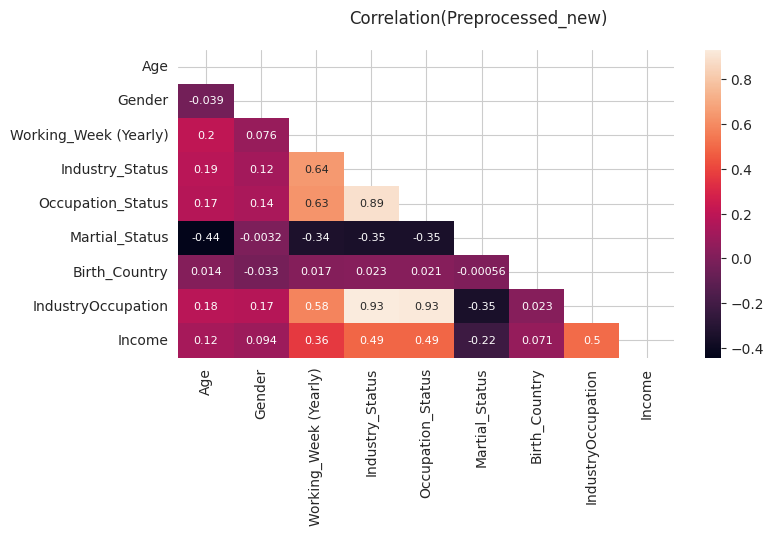

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = train.copy()

corr_matrix = corr_df.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"size":8})
plt.suptitle("Correlation(Preprocessed_new)")
plt.show()

# OLS

In [ ]:
import statsmodels.api as sm

X = train.drop('Income', axis=1)
y = train['Income']

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     917.7
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:21:45   Log-Likelihood:            -1.5632e+05
No. Observations:               20000   AIC:                         3.127e+05
Df Residuals:                   19991   BIC:                         3.127e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -491.58

# 데이터 분포 확인

['Age' 'Gender' 'Working_Week (Yearly)' 'Industry_Status'
 'Occupation_Status' 'Martial_Status' 'Birth_Country' 'IndustryOccupation'
 'Income']


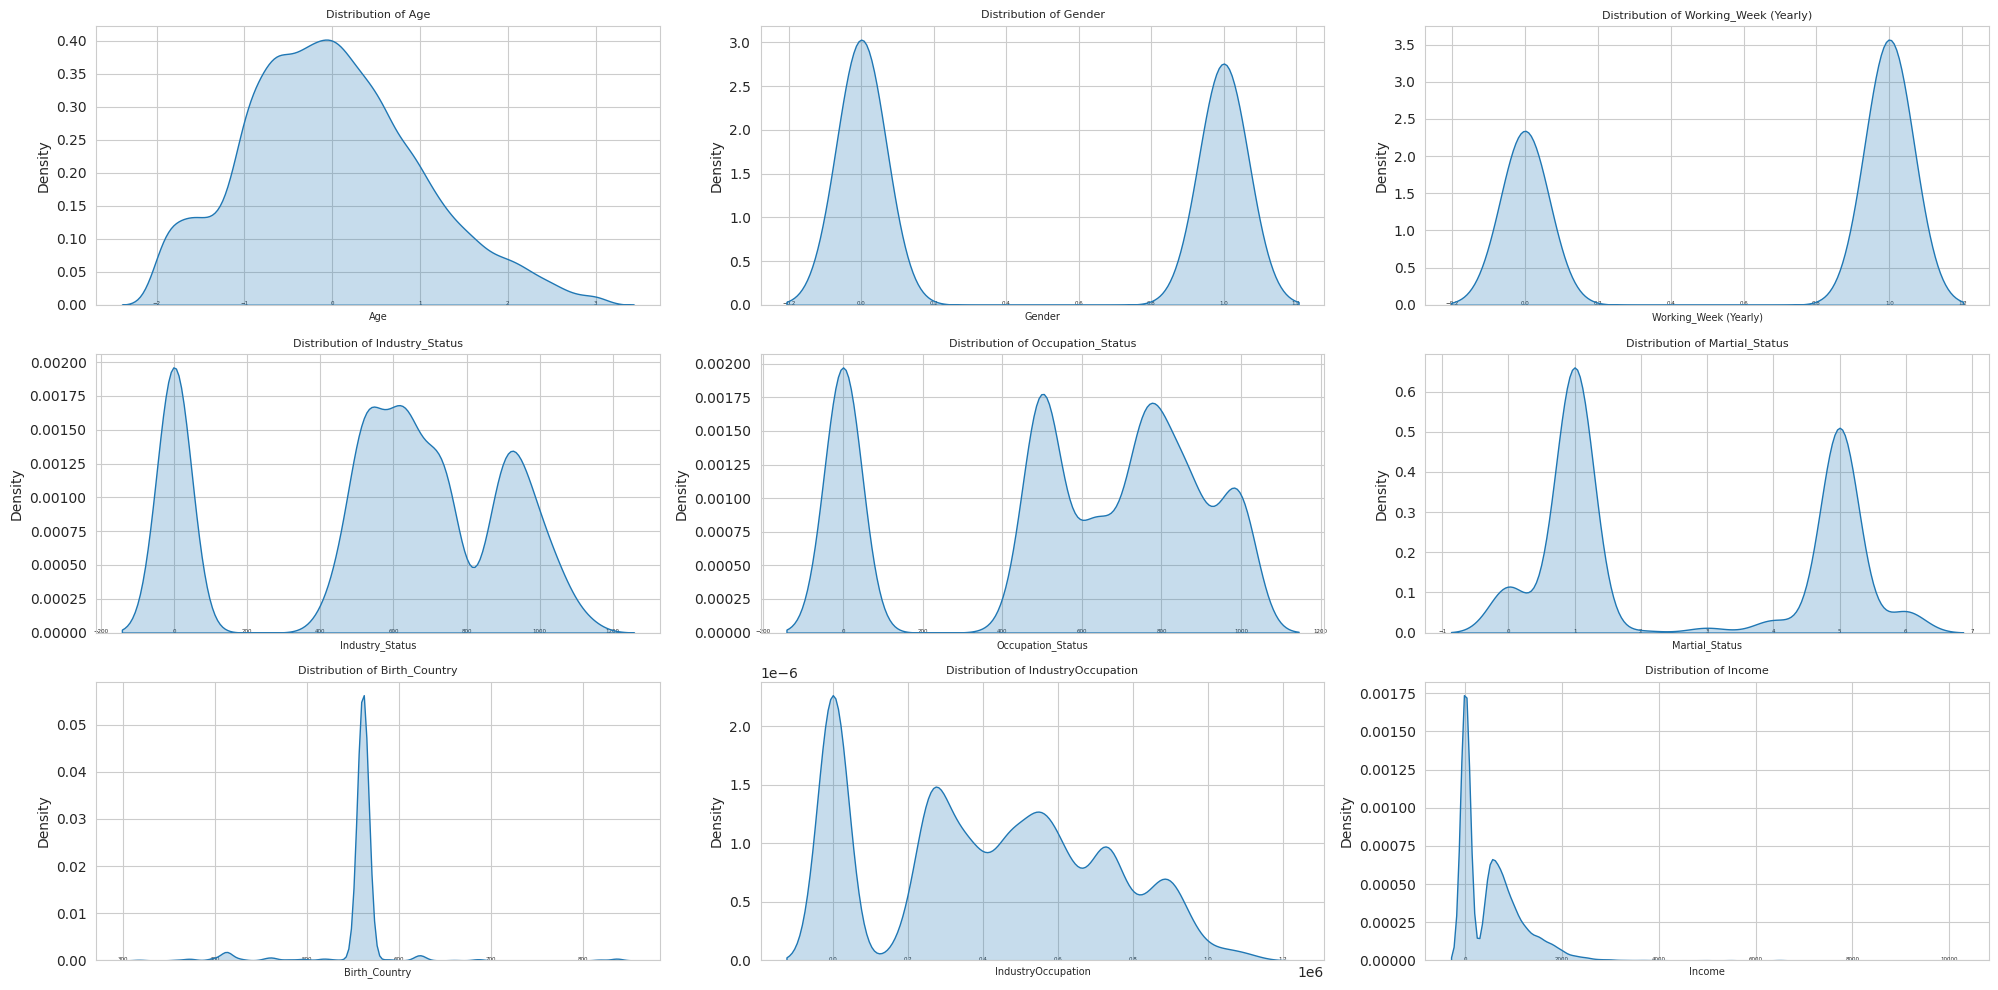

In [ ]:
def features_distribution (df, features):
    i = 0
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(3, 3, figsize=(20, 10))

    for feature in features:
        i+= 1
        plt.subplot(3, 3, i)

        sns.kdeplot(data=train, x=feature, fill=True)
        plt.title(f"Distribution of {feature}", fontsize=8)
        plt.xlabel(feature, fontsize=7)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=4, pad=-6)

    plt.tight_layout()
    plt.show()


features = train.columns.values[:]
print(features)

features_distribution(df=train, features=features)

# 모델링 - 다항릿지회귀

In [ ]:
model = make_pipeline(PolynomialFeatures(degree=2), Ridge())

model.fit(X_train, y_train)
pred = model.predict(X_test)
pred

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.62922e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


array([ 486.48717196,  -36.19704524,   13.10932722, ..., 1003.93223183,
        935.62645111, 1265.5472263 ])

In [ ]:
ridge_mse = mean_squared_error(y_test, pred)
ridge_mae = mean_absolute_error(y_test, pred)
ridge_r2 = r2_score(y_test, pred)

print("MSE:", ridge_mse)
print("MAE:", ridge_mae)
print("R^2 상관계수:", ridge_r2)

MSE: 371089.2165457255
MAE: 350.10158440088424
R^2 상관계수: 0.2837222427532804
